<a href="https://colab.research.google.com/github/xinconggg/Machine-Learning/blob/main/Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup
Requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

Have to use Keras 2 instead of 3. To do that, set the `TF_USE_LEGACY_KERAS` environment variable to "1" and import the `tf_keras` package. This ensures that `tf.keras` points to `tf_keras`, which is Keras 2.*.

In [2]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import tf_keras

And TensorFlow ≥ 2.8:



In [3]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

## Learning to Optimize Rewards
In reinforcement learning, a software agent makes observations and takes actions within an environment, and in
return it receives rewards from the environment. Its objective is to learn to act in a way that will maximize its
expected rewards over time. For example:
1. The agent can be the program controlling a robot. In this case, the environment is the real world, the agent
observes the environment through a set of sensors such as cameras and touch sensors, and its actions consist
of sending signals to activate motors. It may be programmed to get positive rewards whenever it approaches
the target destination, and negative rewards whenever it wastes time or goes in the wrong direction.
2. The agent can be the program controlling Ms. Pac-Man. In this case, the environment is a simulation of the
Atari game, the actions are the nine possible joystick positions (upper left, down, center, and so on), the
observations are screenshots, and the rewards are just the game points.
3. Similarly, the agent can be the program playing a board game such as Go. It only gets a reward if it wins.
4. The agent does not have to control a physically (or virtually) moving thing. For example, it can be a smart
thermostat, getting positive rewards whenever it is close to the target temperature and saves energy, and
negative rewards when humans need to tweak the temperature, so the agent must learn to anticipate human
needs.
5. The agent can observe stock market prices and decide how much to buy or sell every second. Rewards are
obviously the monetary gains and losses.

## Introduction to OpenAI Gym
Let's import Gym and make a new CartPole environment:

In [4]:
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    %pip install -q -U gymnasium swig
    %pip install -q -U gymnasium[classic_control,box2d,atari,accept-rom-license]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 47.4 MB/s eta 0:00:00


In [5]:
import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="rgb_array")

After the environment is created, we must initialize it using the `reset()` method. This returns the first observation. Observations depend on the type of environment. For the CartPole
environment, each observation is a 1D NumPy array containing four floats representing the cart’s horizontal
position (0.0 = center), its velocity (positive means right), the angle of the pole (0.0 = vertical), and its angular
velocity (positive means clockwise). The `reset()` method also returns a dictionary that may contain extra
environment-specific information. This can be useful for debugging or for training. For example, in many Atari
environments, it contains the number of lives left.

Let's initialize the environment by calling is `reset()` method:

In [6]:
obs, info = env.reset(seed=42)
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [7]:
info

{}

Let’s call the `render()` method to render this environment as an image. Since we set `render_mode="rgb_array"`
when creating the environment, the image will be returned as a NumPy array:

In [8]:
img = env.render()
img.shape  # height, width, channels (3 = Red, Green, Blue)

(400, 600, 3)

Use Matplotlib's `imshow()` function to render and plot the an environment:

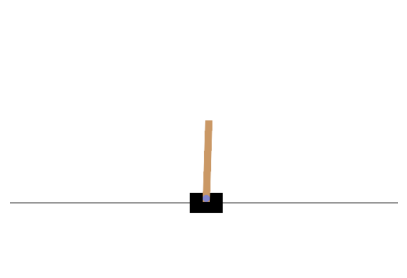

In [9]:
import matplotlib.pyplot as plt

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

Now let's ask the environment what actions are possible:

In [10]:
env.action_space

Discrete(2)

`Discrete(2)` means that the possible actions are integers 0 and 1, which represent accelerating left or right. Other
environments may have additional discrete actions, or other kinds of actions. Since the pole is
leaning toward the right (`obs[2] > 0`), let’s accelerate the cart toward the right:

In [11]:
action = 1  # accelerate right
obs, reward, done, truncated, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

Notice that the cart is now moving toward the right (`obs[1] > 0`). The pole is still tilted toward the right (`obs[2] > 0`), but its angular velocity is now negative (`obs[3] < 0`), so it will likely be tilted toward the left after the next step.

Display the environment:

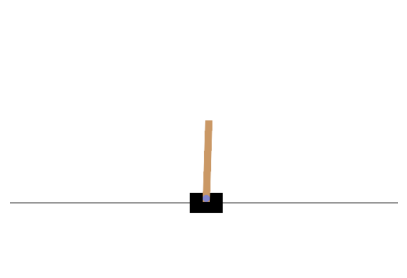

In [12]:
plot_environment(env)
plt.show()

The environment also tells the agent how much reward it got during the last step:



In [13]:
reward

1.0

When the game is over, the environment returns `done=True`. In this case, it's not over yet:



In [14]:
done

False

Some environment wrappers may want to interrupt the environment early. For example, when a time limit is reached or when an object goes out of bounds. In this case, `truncated` will be set to **True**. In this case, it's not truncated yet:



In [15]:
truncated

False

### A Simple Hard-Coded Policy
Let's hard code a simple strategy: if the pole is tilting to the left, then push the cart to the left, and vice versa. We will run this policy to see the average rewards it gets over 500
episodes:

In [16]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break

    totals.append(episode_rewards)

Look at the results:

In [17]:
import numpy as np

np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

As expected, this strategy is a bit too basic: the best it did was to keep the poll up for only 63 steps. This environment is considered solved when the agent keeps the poll up for 200 steps. Even with 500 tries, this policy never managed to keep the pole upright for more than 63 consecutive steps. Not
great. Let’s see if a neural network can come up with a better
policy.

Let's visualize one episode:

In [20]:
import matplotlib.animation
import matplotlib.pyplot as plt

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

In [21]:
np.random.seed(42)

show_one_episode(basic_policy)

## Neural Network Policies
Let’s create a neural network policy. This neural network will take an observation as input, and it will output the
action to be executed, just like the policy we hardcoded earlier. More precisely, it will estimate a probability for
each action, and then we will select an action randomly, according to the estimated probabilities. In the case of the CartPole environment, there are just two possible actions (left or right), so we only need one
output neuron. It will output the probability p of action 0 (left), and of course the probability of action 1 (right) will
be 1 – p. For example, if it outputs 0.7, then we will pick action 0 with 70% probability, or action 1 with 30%
probability.

The following code builds a basic neural network policy using Keras:

In [22]:
import tensorflow as tf

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

We use a `Sequential` model to define the policy network. The number of inputs is the size of the observation
space—which in the case of CartPole is 4—and we have just five hidden units because it’s a fairly simple task.
Finally, we want to output a single probability—the probability of going left—so we have a single output neuron
using the sigmoid activation function. If there were more than two possible actions, there would be one output
neuron per action, and we would use the softmax activation function instead.

Let's write a small policy function that will use the neural net to get the probability of moving left, then let's use it to run one episode:



In [23]:
def pg_policy(obs):
    left_proba = model.predict(obs[np.newaxis], verbose=0)[0][0]
    return int(np.random.rand() > left_proba)

np.random.seed(42)

show_one_episode(pg_policy)

## Policy Gradients (PG)
PG algorithms optimize the parameters of a policy by following the gradients toward higher
rewards. Below is a common variant:
1. First, let the neural network policy play the game several times, and at each step, compute the gradients that
would make the chosen action even more likely—but don’t apply these gradients yet.
2. Once you have run several episodes, compute each action’s advantage, using the method described in the
previous section.
3. If an action’s advantage is positive, it means that the action was probably good, and you want to apply the
gradients computed earlier to make the action even more likely to be chosen in the future. However, if the
action’s advantage is negative, it means the action was probably bad, and you want to apply the opposite
gradients to make this action slightly less likely in the future. The solution is to multiply each gradient vector
by the corresponding action’s advantage.
4. Finally, compute the mean of all the resulting gradient vectors, and use it to perform a gradient descent step.

Let’s use Keras to implement this algorithm. We will train the neural network policy we built earlier so that it
learns to balance the pole on the cart. First, we need a function that will play one step. We will pretend for now that
whatever action it takes is the right one so that we can compute the loss and its gradients. These gradients will just
be saved for a while, and we will modify them later depending on how good or bad the action turned out to be:

In [24]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

Walk through of the function:
- Within the GradientTape block, we start by calling the model, giving it a single
observation. We reshape the observation so it becomes a batch containing a single instance, as the model
expects a batch. This outputs the probability of going left.
- Next, we sample a random float between 0 and 1, and we check whether it is greater than `left_proba`. The
action will be False with probability `left_proba`, or True with probability **1 – `left_proba`**. Once we cast
this Boolean to an integer, the action will be 0 (left) or 1 (right) with the appropriate probabilities.
- We now define the target probability of going left: it is 1 minus the action (cast to a float). If the action is 0
(left), then the target probability of going left will be 1. If the action is 1 (right), then the target probability
will be 0.
- Then we compute the loss using the given loss function, and we use the tape to compute the gradient of the
loss with regard to the model’s trainable variables. Again, these gradients will be tweaked later, before we apply them, depending on how good or bad the action turned out to be.
- Finally, we play the selected action, and we return the new observation, the reward, whether the episode is
ended or not, whether it is truncated or not, and of course the gradients that we just computed.

Now let’s create another function that will rely on the `play_one_step()` function to play multiple episodes,
returning all the rewards and gradients for each episode and each step:

In [25]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

This code returns a list of reward lists: one reward list per episode, containing one reward per step. It also returns a
list of gradient lists: one gradient list per episode, each containing one tuple of gradients per step and each tuple
containing one gradient tensor per trainable variable

The algorithm will use the `play_multiple_episodes() `function to play the game several times (e.g., 10 times),
then it will go back and look at all the rewards, discount them, and normalize them. To do that, we need a couple
more functions:
- the first will compute the sum of future discounted rewards at each step.
- the second will
normalize all these discounted rewards (i.e., the returns) across many episodes by subtracting the mean and
dividing by the standard deviation

In [26]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Check if that works:

In [27]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

Say there were 3 actions, and after each action there was a reward: first 10, then 0, then -50. If we use a discount factor of 80%, then the 3rd action will get -50 (full credit for the last reward), but the 2nd action will only get -40 (80% credit for the last reward), and the 1st action will get 80% of -40 (-32) plus full credit for the first reward (+10), which leads to a discounted reward of -22.

To normalize all discounted rewards across all episodes, we compute the mean and standard deviation of all the discounted rewards, and we subtract the mean from each discounted reward, and divide by the standard deviation:



In [28]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]],
                               discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

Now let’s define the hyperparameters. We will run 150 training
iterations, playing 10 episodes per iteration, and each episode will last at most 200 steps. We will use a discount
factor of 0.95:

In [29]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

Let's create the neural net and reset the environment, for reproducibility:


In [30]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

obs, info = env.reset(seed=42)

We also need an optimizer and the loss function. A regular Nadam optimizer with learning rate 0.01 will do just
fine, and we will use the binary cross-entropy loss function because we are training a binary classifier (there are
two possible actions—left or right):

In [31]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

Now we are ready to build and run the training loop:

In [ ]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)

    # Displays some debug info during training
    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")

    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 132/150, mean rewards: 195.2

Display the animation of one episode:

In [ ]:
np.random.seed(42)

show_one_episode(pg_policy)

## Q-Learning
Q-learning works by watching
an agent play (e.g., randomly) and gradually improving its estimates of the Q-values. Once it has accurate Q-value
estimates (or close enough), then the optimal policy is just choosing the action that has the highest Q-value (i.e.,
the greedy policy).
<br>**Q-Learning Algorithm:**<br>
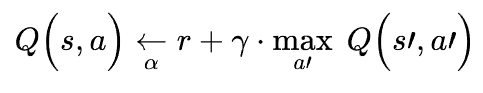

Let’s implement the Q-learning algorithm. First, we will need to make an agent explore the environment. For this,
we need a step function so that the agent can execute one action and get the resulting state and reward:

In [ ]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

Now let’s implement the agent’s exploration policy. Since the state space is pretty small, a simple random policy
will be sufficient. If we run the algorithm for long enough, the agent will visit every state many times, and it will
also try every possible action many times:

In [ ]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

Initialize the Q-values:

In [ ]:
np.random.seed(42)
possible_actions = [[0, 1, 2], [0, 2], [1]]

Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

Next, we are ready to run the Q-learning algorithm with learning
rate decay (using power scheduling):

In [ ]:
alpha0 = 0.05  # initial learning rate
decay = 0.005  # learning rate decay
gamma = 0.90  # discount factor
state = 0  # initial state
history2 = []  # extra code – needed for the figure below

transition_probabilities = [  # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]

for iteration in range(10_000):
    history2.append(Q_values.copy())  # extra code
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = Q_values[next_state].max()  # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)

This algorithm will converge to the optimal Q-values, but it will take many iterations, and possibly quite a lot of
hyperparameter tuning.

Show an animation of the trained DQN playing one episode:

In [ ]:
show_one_episode(epsilon_greedy_policy)

## Implementing Deep Q-Learning
To reduce the algorithm’s sensitivity to large error, we need to implement a Deep Q-Network (DQN). To solve the CartPole
environment, we do not need a very complicated neural net; a couple of hidden layers will do:

In [ ]:
tf.random.set_seed(42)

input_shape = [4]  # == env.observation_space.shape
n_outputs = 2  # == env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

To select an action using this DQN, we pick the action with the largest predicted Q-value. To ensure that the agent
explores the environment, we will use an ε-greedy policy (i.e., we will choose a random action with probability ε):

In [ ]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)  # random action
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()  # optimal action according to the DQN

Instead of training the DQN based only on the latest experiences, we will store all experiences in a *replay buffer
(or replay memory)*, it will contain the agent's experiences, in the form of tuples: `(obs, action, reward, next_obs, done)`, and we will sample a random training batch from it at each training iteration. This helps
reduce the correlations between the experiences in a training batch, which tremendously helps training. For this,
we will just use a double-ended queue (`deque`):





In [ ]:
from collections import deque

replay_buffer = deque(maxlen=2000)

We will need a small function to sample a
random batch of experiences from the replay buffer. It will return 6 NumPy arrays corresponding to the 6
experience elements:

In [ ]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]  # [states, actions, rewards, next_states, dones, truncateds]

Let’s also create a function that will play a single step using the ε-greedy policy, then store the resulting experience
in the replay buffer:

In [ ]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

Finally, let’s create one last function that will sample a batch of experiences from the replay buffer and train the
DQN by performing a single gradient descent step on this batch:

In [ ]:
# For reproducibility, and to generate the next figure
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

In [ ]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

Now we can train the model:

In [ ]:
for episode in range(600):
    obs, info = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    # Displays debug info, stores data for the next figure, and keeps track of the best model weights so far
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)  # Restores the best model weights

Show an animation of the trained DQN playing one episode:

In [ ]:
show_one_episode(epsilon_greedy_policy)